# Fitting a Gaussian Process to USGS Bathymetry Data

In [16]:
# All imports here...

# Numpy and linear algebra libraries
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import progressbar
import imp
from multiprocessing import Process, Value, Array

import csv

import tensorly as tl
import itertools

import TensorToolbox.multilinalg as mla
import TensorToolbox as DT
from TensorToolbox.core import STT
import SpectralToolbox
from sklearn.externals.joblib import Parallel, delayed

import gaussian_process as GP

Plotting data...


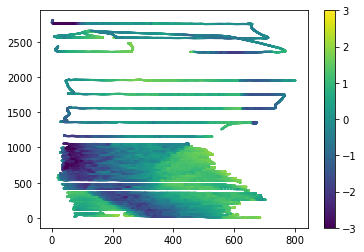

Plotting complete.


In [29]:
FILENAME = 'data/usgs_bath_data/capstone_data_sample.csv'
data=[]
meanHeight = 0

# Angle to rotate the river data by
ROT_ANGLE = 0.13 * np.pi

# Rotate to align river with axes
ROT_MATRIX = np.array([
        [np.cos(ROT_ANGLE), -np.sin(ROT_ANGLE),  0],
        [np.sin(ROT_ANGLE),  np.cos(ROT_ANGLE),  0],
        [0,                  0,                  1]
        ], dtype=float)

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = matplotlib.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def import_data():
    global data
    with open(FILENAME) as csvfile:
        filereader = csv.reader(csvfile, delimiter=',')
        header = True
        for row in filereader:
            if header:
                header = False
            else:
                data.append([float(row[1]), float(row[2]), float(row[4])])

    data = np.array(data, dtype=float)
    data = data.transpose()

def preprocess(data):
    '''
    Translate / rotate the data, normalize it so that it has mean 0.
    :param data:
    :return:
    '''
    global meanHeight
    data[0, :] -= min(data[0, :])
    data[1, :] -= min(data[1, :])
    meanHeight = np.mean(data[2, :])
    data[2, :] -= meanHeight

def plotData(data, colors):
    print("Plotting data...")
    plt.figure()
    plt.scatter(data[0, :], data[1, :], c = colors, s = 1, vmin=-3, vmax=3)
    plt.colorbar()
    plt.show()
    print("Plotting complete.")

import_data()
data = np.matmul(ROT_MATRIX, data)
preprocess(data)
plotData(data, data[2, :])

### Gaussian Process w/ simple subset-of-data approximation

In [35]:
imp.reload(GP)

# Build the Gaussian process (using the homemade GaussianProcess class)
sampleSize = 1600
gp = GP.GaussianProcess('RBF')
sample = np.random.permutation(data.transpose())[:sampleSize]

print("Building Gaussian Process...")
gp.build_sd(sample[:, 0:2], sample[:, 2:3], 0.01)
print("Built Gaussian Process...")

Building Gaussian Process...
Itr: 599
Built Gaussian Process...


### GP with Induced Inputs (Requires Gradient Ascent on Log Marginal Likelihood)

### Querying from the Gaussian Process

100% (3000 of 3000) |####################| Elapsed Time: 0:02:39 Time:  0:02:39

Plotting data...


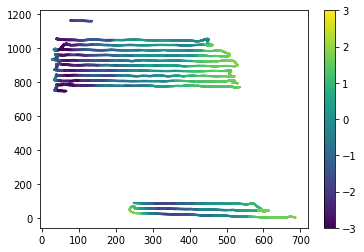

Plotting complete.
Plotting data...


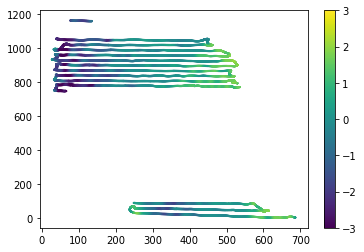

Plotting complete.


In [36]:
# Query the GP; we can use multithreading to do this efficiently...
predMeans = Array('f', len(data.transpose()))

threads = []
numThreads = 9
threadWidth = 3000

def threadFunc(tid, predMeans):
    for i in progressbar.progressbar(range(threadWidth)):
        predMeans[tid * threadWidth + i] = gp.query(data.transpose()[tid * threadWidth + i, 0:2])

# For convenience, work exclusively with the first m points in the dataset
for i in range(numThreads):
    threads.append(Process(target=threadFunc, args=(i,predMeans)))
    threads[-1].start()
    
for t in threads:
    t.join()
    
plotData(data[:, 0:threadWidth * numThreads], data[2, 0:threadWidth * numThreads])
plotData(data[:, 0:threadWidth * numThreads], predMeans[0:threadWidth * numThreads])
    